In [2]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt # to visualize only
from skimage.transform import resize, rescale
from sklearn.model_selection import KFold
from pylab import rcParams

In [3]:
# read in the training data (processed)
data_x_pd = pd.read_csv("./data/processed_x.csv", delimiter=",", header = None) # load from processed images

In [4]:
data_y_pd = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)

In [5]:
# Can see resized 28x28 image
def plotter(images, labels, start):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[start:start+5], labels[start:start+5])):
        plt.subplot(1, 5, index + 1)
        im = np.reshape(image, (28,28))
        plt.imshow(im, cmap= 'gray')
        plt.title('Training: %i\n' % label, fontsize = 20)

In [1]:
# plotter(x, data_y, 0)

In [6]:
### Prepare Data for Neural Net ###

# only take the first 5000 examples

data_x = data_x_pd.head(5000).values.astype(np.float32)
data_y = np.array(list(map(int, data_y_pd.head(5000)[0].tolist())), dtype=object)

# Normalize x values
data_x /= 255

num_rows = 28
num_cols = num_rows

# numpy array that will hold reshaped data
x = np.zeros((data_x.shape[0], num_rows*num_cols))

# scaling factor
scale = num_rows/64

# Reshape into 28 x 28 image
for i in range(len(x)):
    img = data_x[i].reshape(64,64)
    image = rescale(img, scale, mode = 'reflect')
    image = image.reshape(28**2)
    x[i] = image

In [9]:
# plotter(x, list(range(5)), 0)

In [10]:
# calculate sigmoid of input
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

# calculate derivative of sigmoid at the input
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [27]:
# class for fully connected neural net trained by backprop and using stochastic gradient descent
class Network(object):

    def __init__(self, dims):
        # dims contains number of neurons in each layer
        # first index is dimension of input (eg. size of image)
        # last layer is dimension of output (10 -> 1 of k)
        # length of dims is # of layers of network
        # biases and weights are intialized randomly using Gaussian dist (mean 0, sd 1)
        self.num_layers = len(dims)
        self.dims = dims
        self.biases = [np.random.randn(y, 1) for y in dims[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(dims[:-1], dims[1:])]
    
    # Feed image through network (used for prediction)
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    # update weights (really just does a call to train)
    def SGD(self, train_data, epochs, mini_batch_size, alpha,
            valid_data, progress = None):
        
        n_valid = len(valid_data) #number of validation examples
        n = len(train_data) #number of training exaples
        
        # Stochastic Gradient Descent with shuffling and full batch processing
        for j in range(epochs):
            random.shuffle(train_data)
            self.train(train_data, alpha) # alpha is learning rate
            valid_score = self.test(valid_data)
            # print(valid_score/len(valid_data)) # optionally print progress as network runs
            
            # this is to keep track of accuracy per epoch, optional
            if progress is not None:
                progress[j] = valid_score          
        return valid_score
        
    def train(self, batch, alpha):
    
        # Gradients to be applied to weights and biases
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in batch:
            # Get gradients through backpropogation
            delta_grad_b, delta_grad_w = self.backprop(x, y)
            grad_b = [new_b+delta_new_b for new_b, delta_new_b in zip(grad_b, delta_grad_b)]
            grad_w = [new_w+delta_new_w for new_w, delta_new_w in zip(grad_w, delta_grad_w)]
            
        # update the weights and biases using learning rate and gradient
        self.weights = [w-(alpha/len(batch))*new_w
                        for w, new_w in zip(self.weights, grad_w)]
        self.biases = [b-(alpha/len(batch))*new_b
                       for b, new_b in zip(self.biases, grad_b)]

    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward to get nets and activations
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backward pass
        # Calculate gradients at output layer
        delta = self.error_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Calculate gradients at all hidden layers starting from last
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (grad_b, grad_w)

    def test(self, valid_data):
        # Translates 1 of k to an integer for determining accuracy
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in valid_data]
        return sum(int(x == y) for (x, y) in test_results)

    def error_derivative(self, output_activations, y):
        # MSE derivative
        return (output_activations-y)

In [28]:
# 5-fold cross validation 
kf = KFold(n_splits=5)
kf.get_n_splits(x)

# Hyper-parameter grid
num_epochs = 5
layer_dims = [[784,100,10],[784,50,10],[784,100,50, 10],
              [784,200,10]]
learning_rates = [1.0, 4.0, 8.0]

# will hold all of the average accuracies for each NN structure 
accuracies = []

# will hold all of the accuracies per epoch per split for each NN structure
progress_per_epoch = np.zeros((len(layer_dims)*len(learning_rates)*5, num_epochs))

In [30]:
pos = 0 
# Run through hyper-parameter grid
for i, dim in enumerate(layer_dims):
    for j, lr in enumerate(learning_rates):
        print("NN dimensions: {}, learning rate: {}, ".format(dim, lr) )
        average_score = 0
        
        # go through every training/validation split
        for train_index, valid_index in kf.split(x):
    
            train_x, valid_x = x[train_index], x[valid_index]
            train_y, valid_y = data_y[train_index], data_y[valid_index]

            # vectorize training targets
            for i in range(len(train_y)):
                vect = np.zeros((10,1), dtype=object)
                vect[train_y[i]] = 1
                train_y[i] = vect.astype(float)

            # reshape and zip train and valid
            training_inputs = [np.reshape(x,(train_x.shape[1],1)) 
                               for x in train_x]
            valid_inputs = [np.reshape(x,(valid_x.shape[1],1)) for x in valid_x]
            training_data = list(zip(training_inputs, train_y))
            valid_data = list(zip(valid_inputs, valid_y))

            # build the neural net
            neural_net = Network(dim)
            
            # get the validation score
            valid_score = neural_net.SGD(training_data, num_epochs, 784, lr, valid_data, progress_per_epoch[pos])
            average_score += valid_score
            pos += 1
        
        # average the score and store it
        average_score/= (5*len(valid_x))
        accuracies.append(average_score)

In [171]:
# trying two more NN architectures

kf = KFold(n_splits=5)
kf.get_n_splits(x)

# Second Hyper-parameter grid
num_epochs = 2500
layer_dims2 = [[784, 50, 100, 10], [784, 70, 30, 70, 10]]
learning_rate = 4.0

accuracies2 = []
progress_per_epoch2 = np.zeros((len(layer_dims2), num_epochs))

In [24]:
pos = 0 
# Run through hyper-parameter grid
for i, dim in enumerate(layer_dims):
    for j, lr in enumerate(learning_rates):
        print("NN dimensions: {}, learning rate: {}, ".format(dim, lr) )
        average_score = 0
        for train_index, valid_index in kf.split(x):
    
            train_x, valid_x = x[train_index], x[valid_index]
            train_y, valid_y = data_y[train_index], data_y[valid_index]

            # vectorize training targets
            for i in range(len(train_y)):
                vect = np.zeros((10,1), dtype=object)
                vect[train_y[i]] = 1
                train_y[i] = vect.astype(float)

            # reshape and zip train and valid
            training_inputs = [np.reshape(x,(train_x.shape[1],1)) 
                               for x in train_x]
            valid_inputs = [np.reshape(x,(valid_x.shape[1],1)) for x in valid_x]
            training_data = list(zip(training_inputs, train_y))
            valid_data = list(zip(valid_inputs, valid_y))


            neural_net = Network(dim)
            valid_score = neural_net.SGD(training_data, num_epochs, 784, lr, valid_data, progress_per_epoch[pos])
            average_score += valid_score
            pos += 1
        average_score/= (5*len(valid_x))
        accuracies.append(average_score)

In [178]:
df = pd.DataFrame(accuracies)
df.to_csv("./data/nn_accuracies.csv", header = False, index = False)

In [201]:
progress_per_epoch /= 1000
df = pd.DataFrame(progress_per_epoch)
df.to_csv("./data/nn_progress.csv", header = False, index = False)

In [182]:
df = pd.DataFrame(accuracies2)
df.to_csv("./data/nn_accuracies2.csv", header = False, index = False)

In [203]:
progress_per_epoch2 /= 1000
df = pd.DataFrame(progress_per_epoch2)
df.to_csv("./data/nn_progress2.csv", header = False, index = False)

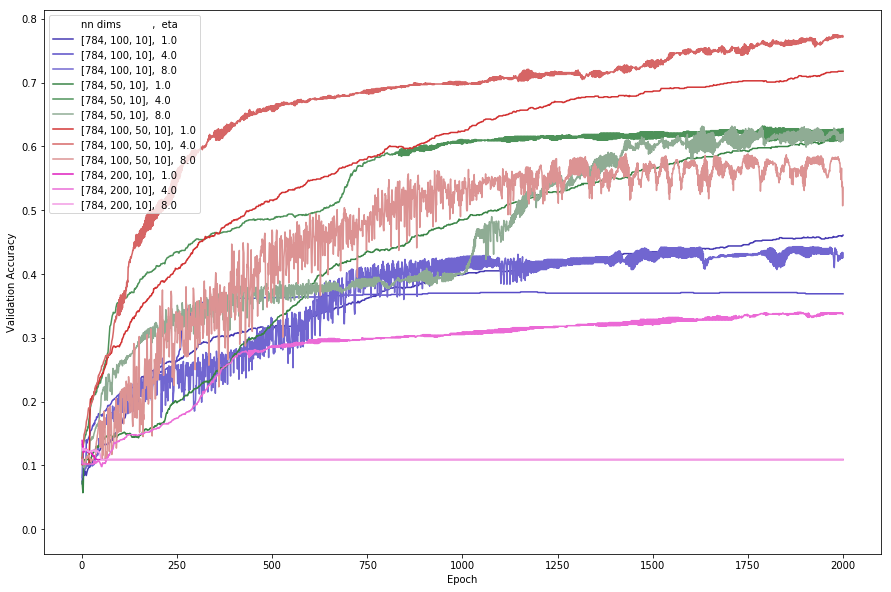

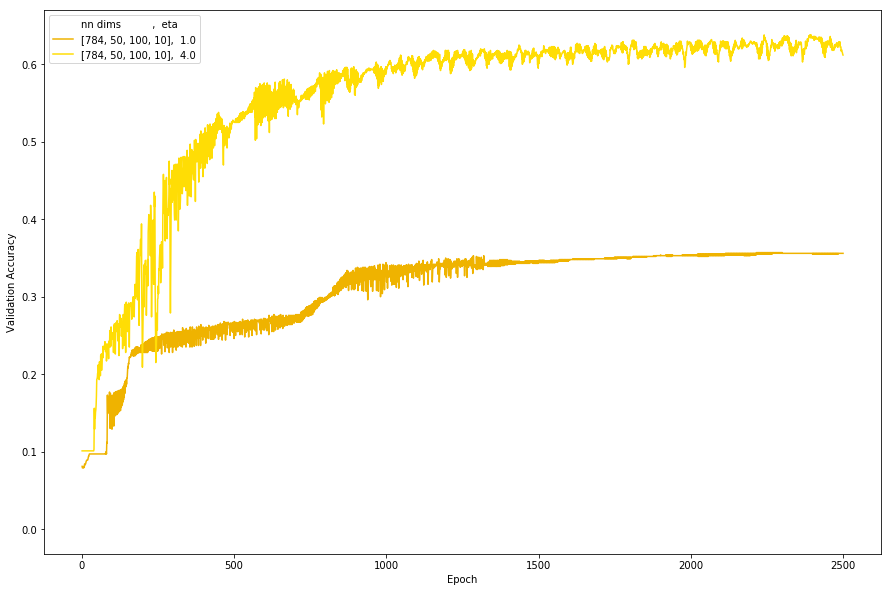

In [283]:
# plotting results

num_epochs1 = list(range(1, 2001))
num_epochs2 = list(range(1, 2501))
rcParams['figure.figsize'] = 15,10
plt.plot(num_epochs1, [0 for i in num_epochs1], "#FFFFFF", label="nn dims          ,  eta")
plt.plot(num_epochs1, progress_per_epoch[0], '#4438B2', label = str(layer_dims[0]) + ",  " + str(learning_rates[0]))
plt.plot(num_epochs1, progress_per_epoch[1], '#574BC7', label = str(layer_dims[0]) + ",  " + str(learning_rates[1]))
plt.plot(num_epochs1, progress_per_epoch[2], '#7166D0', label = str(layer_dims[0]) + ",  " + str(learning_rates[2]))
plt.plot(num_epochs1, progress_per_epoch[3], '#388445', label = str(layer_dims[1]) + ",  " + str(learning_rates[0]))
plt.plot(num_epochs1, progress_per_epoch[4], '#4D9259', label = str(layer_dims[1]) + ",  " + str(learning_rates[1]))
plt.plot(num_epochs1, progress_per_epoch[5], '#8FAC94', label = str(layer_dims[1]) + ",  " + str(learning_rates[2]))
plt.plot(num_epochs1, progress_per_epoch[6], '#D23232', label = str(layer_dims[2]) + ",  " + str(learning_rates[0]))
plt.plot(num_epochs1, progress_per_epoch[7], '#D66565', label = str(layer_dims[2]) + ",  " + str(learning_rates[1]))
plt.plot(num_epochs1, progress_per_epoch[8], '#DC9393', label = str(layer_dims[2]) + ",  " + str(learning_rates[2]))
plt.plot(num_epochs1, progress_per_epoch[9], '#DE1BBD', label = str(layer_dims[3]) + ",  " + str(learning_rates[0]))
plt.plot(num_epochs1, progress_per_epoch[10], '#EB6AD6', label = str(layer_dims[3]) + ",  " + str(learning_rates[1]))
plt.plot(num_epochs1, progress_per_epoch[11], '#F29BE4', label = str(layer_dims[3]) + ",  " + str(learning_rates[2]))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

plt.plot(num_epochs1, [0 for i in num_epochs1], "#FFFFFF", label="nn dims          ,  eta")
plt.plot(num_epochs2, progress_per_epoch2[0], '#EFB300', label = str(layer_dims2[0]) + ",  " + str(learning_rates[0]))
plt.plot(num_epochs2, progress_per_epoch2[1], '#FFDD05', label = str(layer_dims2[0]) + ",  " + str(learning_rates[1]))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()